# Computational Methods for Astrophysics, Homework #1, Askold Vilkha

In [ ]:
#this code has working solutions for interpolation parts of problems 1 and 2. Will add error estimators soon. Derivative part of problem 2 and problem 3 will follow.

In [44]:
#loading libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.utilities import lambdify

## Exercise 1, Lagrange Interpolation

In this problem, we are working with the Runge's function:
$$ f(x) = \frac{1}{1 + 25 x^2}$$
The plot for it is shown in Fig. 1 below.

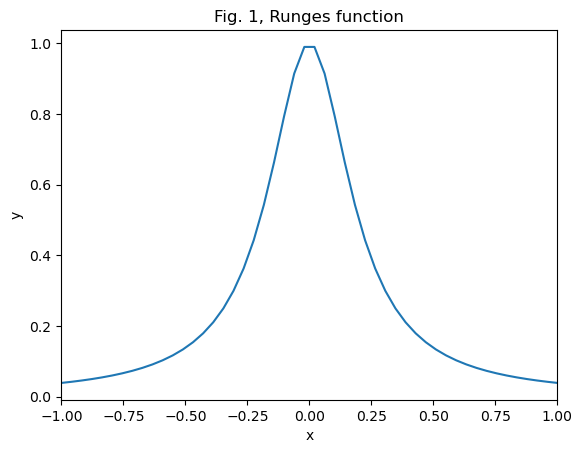

In [26]:
x = np.linspace(-1, 1, 50)
plt.plot(x, 1 / (1 + 25 * x ** 2))
plt.xlim(-1, 1)
plt.xlabel(r'x'); plt.ylabel(r'y')
plt.title(r'Fig. 1, Runges function');

In [3]:
def runge_func (x):
    '''
    Function with the Runges function
    '''
    return 1 / (1 + 25 * x ** 2)

In [4]:
def interp_points (N_points: int):
    '''
    Function with the formula to find x points for the interpolation table
    Input: N_points (int) - number of points
    Output: x_j (np.array) - array of evaluated x_j values
    '''
    x_j = np.zeros(N_points)
    for j in range(N_points):
        x_j[j] = -1 + 2 * j / (N_points - 1)
    return x_j

In [5]:
def stencil_locator (stencil_points: int, x_table, x_test: float):
    '''
    Function that locates the desired number of stencil points given a table of points and a test array of points
    Input: stencil_points (int) - number of stencil points the user needs (in our case it's 4)
    x_table (np.array) - array that contains the table of x points for interpolation
    x_test (float) - test point for which we want to find the closest points
    Output: points_ind (np.array) - array containing the indices of the closest points to x_test in x_table
    '''
    dist = np.abs(x_test - x_table) #array containing the distance from the test point to each of the table points
    points_ind = np.argsort(dist)[:stencil_points]
    return points_ind

In [6]:
def interp_polynom_lagrange (x_test, x_table, y_table, stencil_points: int):
    '''
    Function that contains the main Lagrange interpolation algorythm
    Input: x_test (np.array) - array of x values, for which we are going to interpolate the function
    x_table (np.array) - array of x points at which the function is tabulated 
    y_table (np.array) - array of tabulated y points of the function
    stencil_points (int) - number of points taken from the table around a test point
    Output: polynom (np.array) - resulting interpolation polynom 
    '''
    polynom = np.zeros_like(x_test)
    for k in range(len(x_test)):
        polynom_temp = np.zeros(stencil_points)
        stencil = stencil_locator(stencil_points, x_table, x_test[k])
        for i in stencil:
            for j in stencil:
                stencil_corr = np.delete(stencil, np.where(stencil == i)) #this stencil will skip the point where i and j are the same, so avoid division by zero
                prod_frac_up = x_test[k] - x_table[stencil_corr] #array consisting of the values of x point minus the point from the interpolation table
                prod_frac_down = x_table[i] - x_table[stencil_corr] #array of differences of the x points from the interpolation table
                prod_temp = np.prod(prod_frac_up / prod_frac_down)
                polynom_temp[i-min(stencil)] = y_table[i] * prod_temp #polynom_temp is an array of stencil_points size, we have to start indexing from zero, so we don't get out of bounds
        polynom[k] = np.sum(polynom_temp)
    return polynom


In [7]:
def interp_lagrange (npoints: int, stencil_points: int):
    '''
    Function that calls Lagrange interpolation and plots the error;
    Input: npoints (int) - number of points in the interpolation table;
    stencil_points (int) - number of points taken from the table around a test point;
    '''
    x_table = interp_points(npoints); y_table = runge_func(x_table)
    x_test = np.linspace(-1, 1, 2 * npoints) #we will use at least twice the number of points in the interpolation table, so interpolation makes sense
    interp_res = interp_polynom_lagrange(x_test, x_table, y_table, stencil_points)
    plt.plot(interp_res - runge_func(x_test))

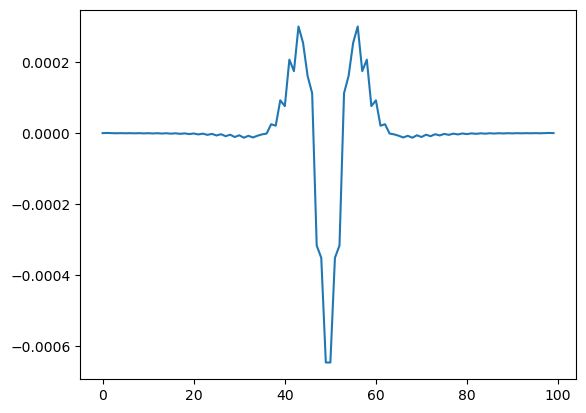

In [8]:
interp_lagrange(50, 4)

# Exercise 2, Chebyshev Interpolation

In [9]:
def Chebyshev_roots (nroots: int):
    '''
    Function that finds Chebyshev roots given a number of points
    Input: npoints (int) -  number of roots the user wants to have
    Output: C_roots (np.array) -  array containing the roots
    '''
    C_roots = np.zeros(nroots)
    for k in range(nroots):
        C_roots[k] = np.cos(np.pi * (2 * k + 1) / (2 * nroots))
    return C_roots
    

In [18]:
def Chebyshev_polynom (x: float, n: int, diff = False):
    '''
    Function that calculates Chebyshev polynomial given a value of x and a number n \n
    Input: x (float) - variable, must be in the interval [-1, 1] \\
    n (int) - an integer number of the polynomial, must not be negative \\
    diff (bool) - if True, the function will calculate first derivative of the polynomial expression \n
    Output: T_n (float) - Chebyshev polynomial for a variable x and a number n
    '''
    if (x < -1) or (x > 1):
        raise ValueError (x, r'Variable x must be in the interval [-1, 1]!')
    if n < 0:
        raise ValueError (n, r'Number n must not be negative!')
    if diff:
        T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
    else: 
        T_n = np.cos(n * np.arccos(x))
    return T_n
    

In [19]:
def Chebyshev_polynom_array (x_array, n: int, diff = False):
    '''
    Function that transforms Chebyshev_polynom results into an array for an array of x values and one number n \n
    Input: x_array (np.array) - array containing x values \\
    n (int) - an integer number of the polynomial, must not be negative \\
    diff (bool) - if True, the function will calculate first derivative of the polynomial expression \n
    Output: T_n_array (np.array) - array of the polynomials correspoding to the array of x_values
    '''
    npoints = len(x_array)
    T_n_array = np.zeros(npoints)
    for i in range(npoints):
        T_n_array[i] = Chebyshev_polynom(x_array[i], n, diff)
    return T_n_array

In [12]:
def Chebyshev_weights (x_roots, y_table):
    '''
    Function that calculates Chebyshev weights and collects them into an array \n
    Input: x_roots (np.array) - array that contains Chebyshev roots \\
    y_table (np.array) - array that contains function values at the roots \n
    Output: C_weights (np.array) - array that contains calculated weights with corresponding indexation
    '''
    nroots = len(x_roots)
    C_weights = np.zeros(nroots)
    C_weights[0] = 1 / nroots * np.sum(y_table * Chebyshev_polynom_array(x_roots, 0))
    for n in np.arange(start = 1, stop = nroots):
        C_weights[n] = 2 / nroots * np.sum(y_table * Chebyshev_polynom_array(x_roots, n))
    return C_weights


In [20]:
def Chebyshev_expansion (x_array, nroots: int, diff =  False):
    '''
    Function that calculates Chebyshev expansion of Runge's function given an array of x_values and number of roots \n
    Input: x_array (np.array) - array of x values to evaluate function over \\
    nroots (int) - number of Chebyshev roots \\
    diff (bool) - if True, the function will be evaluating the derivative of Runge's function \n
    Output: f_exp_cheb (np.array) - resulting Chebyshev expansion of the function as an array corresponding to x_array
    '''
    f_exp_cheb = np.zeros_like(x_array)
    x_roots = Chebyshev_roots(nroots)
    y_table = runge_func(x_roots)
    C_polynom_array = np.zeros(nroots)
    for i in range(len(x_array)):
        for n in range(nroots):
            C_polynom_array[n] = Chebyshev_polynom(x_array[i], n, diff)
        f_exp_cheb[i] = np.sum(Chebyshev_weights(x_roots, y_table) * C_polynom_array)
    return f_exp_cheb

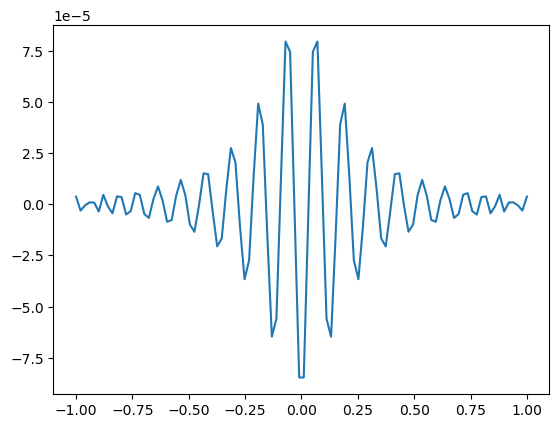

In [14]:
#test plot of error vs x, we use 50 roots here
x_test = np.linspace(-1, 1, 100)
cheb_test = Chebyshev_expansion(x_test, 50)
plt.plot(x_test, cheb_test - runge_func(x_test))

/tmp/ipykernel_9099/290501724.py:14: RuntimeWarning: invalid value encountered in double_scalars
  T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)
/tmp/ipykernel_9099/290501724.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  T_n = n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x ** 2)


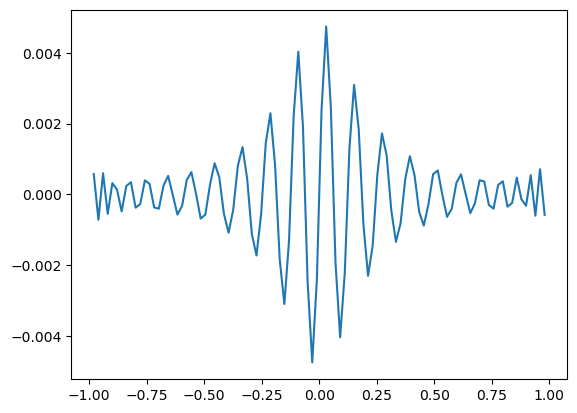

In [54]:
#test of a derivative part of problem 2
x_test_diff = np.linspace(-1, 1, 100)
cheb_test_diff = Chebyshev_expansion(x_test_diff, 50, diff=True)

x_sym = symbols('x') #we need to define a symbollic variable to work with sympy and not get confused with numeric variables
runge_deriv_sym = diff(1 / (1 + 25 * x_sym**2), x_sym) #this exppression is symbollic, not suited to work with np.arrays
runge_deriv_func = lambdify(x_sym, runge_deriv_sym, 'numpy') #this line converts the symbollic expression into a numeric one, function like so we can plug an array here

#plt.plot(x_test_diff, runge_deriv_func(x_test_diff))
plt.plot(x_test_diff, cheb_test_diff - runge_deriv_func(x_test_diff))

## Exercise 3, Derivative Calculator

In [57]:
test_func = diff(sqrt(1 - x_sym**2), x_sym)
test_func.subs(x_sym, .5)

-0.577350269189626